In [114]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist, mnist
import numpy as np
import shap
import json
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

In [28]:
import warnings
warnings.filterwarnings('ignore')

## Wyjaśnianie predykcji modelu przy pomocy algorytmów z rodziny Shap

Shap to zbiór metod pozwalających na lokalne wyjaśnienie wyników predykcji modelu. Lokalność oznacza w tym pzypadku analizowanie predykcji dla konkretnej próbki wejściowej, a nie próba zinterpretowania wewnętrznej wiedzy modelu. Nazwa metody pochodzi od znanych z teorii gier współczynników "Shap values", które opisują najbardziej sprawiedliwy podział nagrody uzyskanej w wyniku gry kooperacyjnej pomiędzy graczy biorących udział w grze - każdy otrzymuje odpowiednią część wygranej według kontrybucji do uzyskania nagrody.

W ogólnym założeniu podział nagrody między graczy opiera się o następujące zasady:
- Additivity: suma nagród dla poszczególnych graczy jest równa nagrodzie całego zespołu
- Consistency: gracze mający większy wpływ na zysk zespołu nie powinni otrzymać nagrody mniejszej od graczy mniej wpływowych

W przypadku interpretowalności modelu współczynniki Shap values są wykorzystywane, aby obliczyć wkład każdej cechy próbki wejściowej do wyników predykcji.

Więcej na temat teorii stojącej za algorytmami Shap można znaleźć na przykład tutaj:
https://youtu.be/0yXtdkIL3Xk

In [37]:
def prep_img(img):
    return np.array([img / 255])

## Ładowanie datasetu

In [3]:
data = tf.keras.datasets.cifar10.load_data()

In [21]:
train_data, test_data = data
X_train, y_train = train_data
X_test, y_test = test_data

y_train = y_train.flatten()
y_test = y_test.flatten()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train_prep = X_train.copy()
X_train_prep = preprocess_input(X_train_prep)

X_test_prep = X_test.copy()
X_test_prep = preprocess_input(X_test_prep)

In [5]:
X_train_prep.shape, X_test_prep.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [45]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

shap_labels = np.array([list(class_names.values())])

## Konfiguracja modelu sieci

In [9]:
input_shape = X_train[0].shape
num_classes = 10

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)               

In [22]:
model.load_weights('cifar_weights_custom_5.1.h5')
test_preds = model.predict(X_test_prep)
test_preds_classes = np.argmax(test_preds, axis=-1)
test_accuracy = np.mean(test_preds_classes == y_test)

print('test accuracy:', round(test_accuracy, 2))

test accuracy: 0.75


## Konstrukcja deep explainera

In [142]:
# background = np.zeros((1, 32, 32, 3))
background = X_train_prep[np.random.choice(X_train_prep.shape[0], 100, replace=False)]
# background = np.mean(X_train_prep.reshape(-1, 32 * 32 * 3), axis=0).reshape(1, 32, 32, 3)
explainer = shap.DeepExplainer(model, background)

airplane:	0.0
automobile:	1.0
bird:	0.0
cat:	0.0
deer:	0.0
dog:	0.0
frog:	0.0
horse:	0.0
ship:	0.0
truck:	0.0


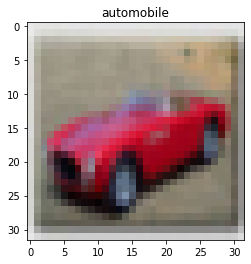

In [143]:
sample_idx = 1234
sample_img = X_test[sample_idx]
sample_img_prep = X_test_prep[sample_idx]

sample_label = y_test[sample_idx]
sample_pred = test_preds[sample_idx]

for i in range(10):
    rounded_pred = str(sample_pred[i].round(3))
    print(f'{class_names[i]}:\t{rounded_pred}')
    
plt.imshow(sample_img)
plt.title(class_names[sample_label])
plt.show()

In [323]:
%%time
batch = sample_img_prep[np.newaxis, :]
batch_shap = explainer.shap_values(batch)
sample_img_shap = batch_shap[0]

CPU times: user 13.7 s, sys: 405 ms, total: 14.1 s
Wall time: 7.37 s


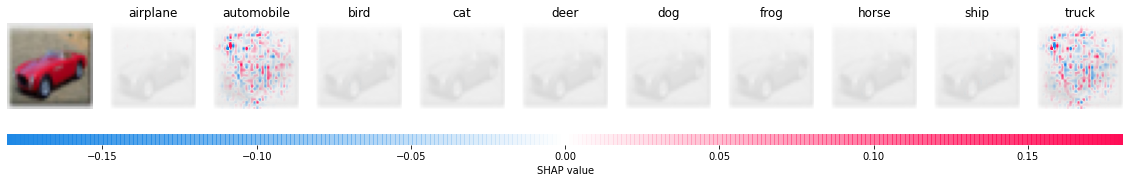

In [145]:
shap.image_plot(batch_shap, prep_img(sample_img), labels=shap_labels)

In [202]:
len(batch_shap), batch_shap[0].shape

(10, (1, 32, 32, 3))

## Wizualizacja zbioru danych przy pomocy PCA

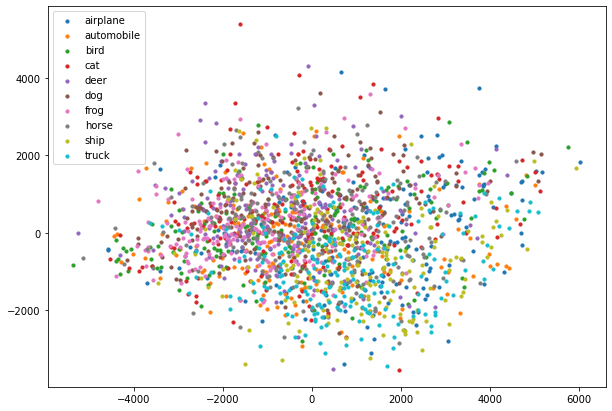

In [111]:
batch_size = 2_000
batch_indices = np.random.choice(len(X_train), batch_size, replace=False)
X_batch = X_train[batch_indices].reshape((-1, 32 * 32 * 3))
batch_labels = y_train[batch_indices]

pca = PCA(n_components=2).fit(X_batch)
X_batch_2d = pca.transform(X_batch)

plt.figure(figsize=(10, 7))

for i, name in class_names.items():
    class_indices = batch_labels == i
    X_class = X_batch_2d[class_indices]
    plt.scatter(X_class[:, 0], X_class[:, 1], s=10, label=name)
    
plt.legend()
plt.show()

Niestety PCA nie pozwoliło uzyskać informacji na temat potencjalnych podobieństw pomiedzy poszczególnymi klasami.

## Analiza confusion matrix dla predykcji na zbiorze testowym

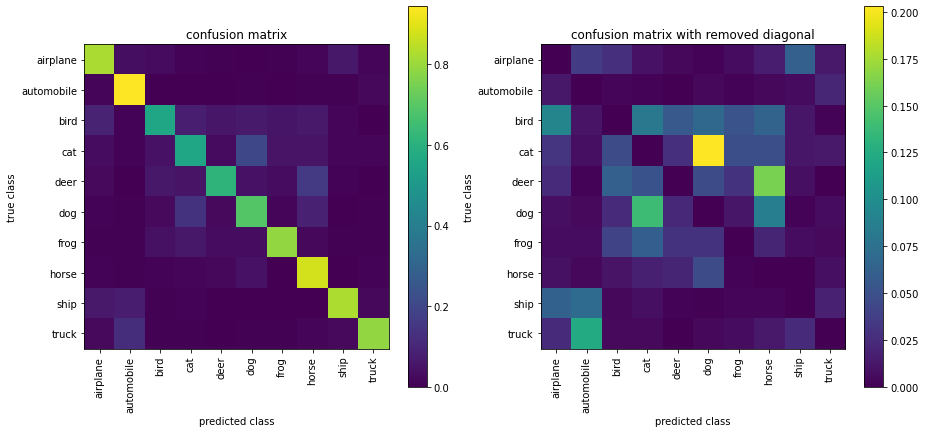

In [141]:
conf_mat = confusion_matrix(y_test, test_preds_classes, normalize='true')

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(conf_mat)
labels = list(class_names.values())
plt.xticks(range(10), labels=labels, rotation=90)
plt.yticks(range(10), labels=labels)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('confusion matrix')
plt.colorbar()

plt.subplot(1, 2, 2)
conf_mat_masked = conf_mat.copy()
for i in range(10):
    conf_mat_masked[i, i] = 0
    
plt.imshow(conf_mat_masked)
labels = list(class_names.values())
plt.xticks(range(10), labels=labels, rotation=90)
plt.yticks(range(10), labels=labels)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('confusion matrix with removed diagonal')
plt.colorbar()

plt.show()

Dzięki analizie confusion matrix dochodzimy do wniosku, że model najczęściej myli między sobą zdjęcia następujących klas:
- koty vs psy
- konie vs jelenie
- samochody vs ciężarówki
- ptaki vs samoloty

## Analiza Shap values - porównanie kluczowych obszarów obrazków dla podobnych klas

W tej części postanowiliśmy zbadać, które obszary zdjęć wejściowych są dla modelu kluczowe w przypadku rozróżnienia pomiędzy dwoma klasami. W tym celu wybraliśmy przykłady ze zbioru testowego, które zostały poprawnie zaklasyfikowane przez model, a następnie szukaliśmy na nich charakterystycznych cech wyróżniających daną klasę. Bardzo pomocne przy analizie Shap values okazało się przetworzenie wyników explainera przez filtr z rozmyciem gaussowskim - dzięki niemu heatmapa prezentująca wkład pikseli w predykcje jest zdecydowanie mniej zaszumiona i łatwiejsza do analizy.

In [303]:
def compare_shap(shap_values, explained_classes, imgs, separate_samples=False):
    np_shap = np.array(shap_values)
    class_labels = [class_names[c] for c in explained_classes]
    
    if separate_samples:
        classes_shap = np_shap[explained_classes]

        for i, img in enumerate(imgs):
            img_shap = list(classes_shap[:, i:i+1])
            shap.image_plot(img_shap, prep_img(img), [class_labels])
            
    else:
        classes_shap = list(np_shap[explained_classes])    
        labels = [class_labels] * len(imgs)
        shap.image_plot(classes_shap, imgs / 255, labels=labels)
        
        
def blur_shap_values(shap_values, sigma):
    classes_count = len(shap_values)
    samples_count = shap_values[0].shape[0]
    
    blurred_shap_values = []
    for class_idx in range(classes_count):
        blurred = []
        for sample_idx in range(samples_count):
            blurred.append(gaussian_filter(shap_values[class_idx][sample_idx], sigma=sigma))
        blurred_shap_values.append(blurred)
    return blurred_shap_values

## Analiza Shap values: koty vs psy

In [300]:
cat_class = 3
dog_class = 5

# recznie wybrane przyklady
cat_indices = [103, 336, 432, 558, 573, 673, 874]
dog_indices = [39, 42, 181, 190, 207, 232, 319]

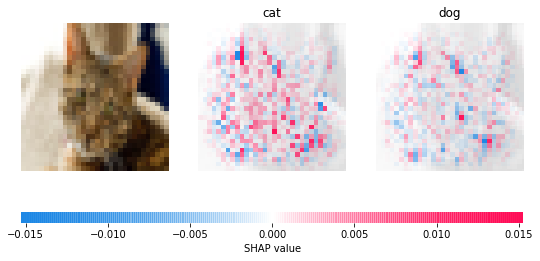

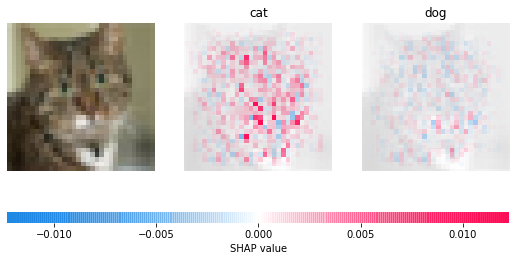

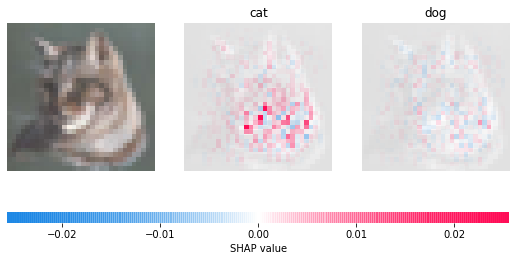

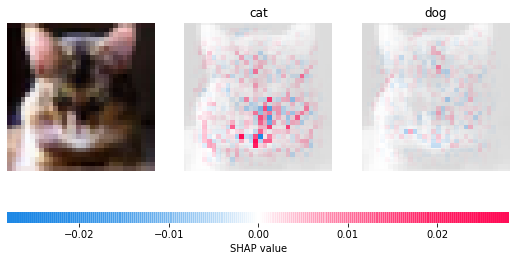

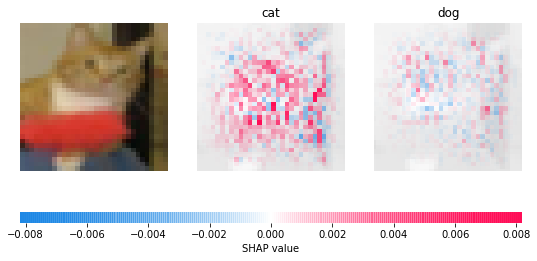

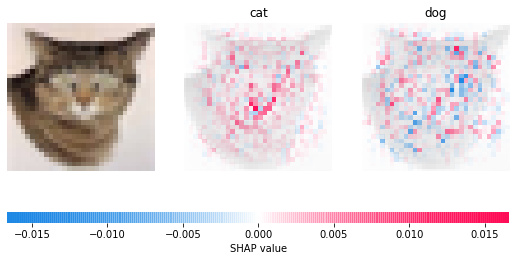

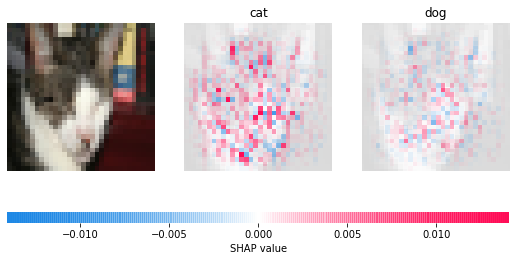

In [305]:
indices = cat_indices
samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [cat_class, dog_class], samples, True)

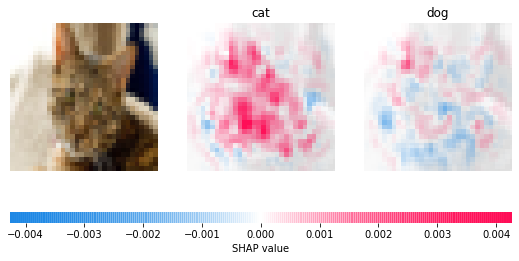

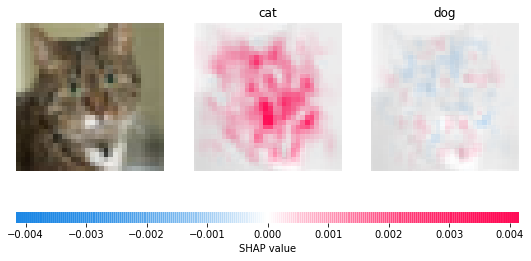

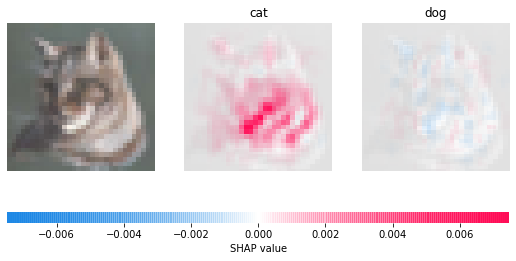

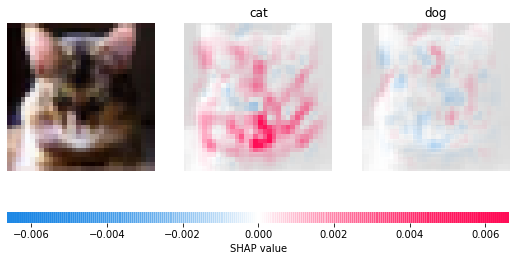

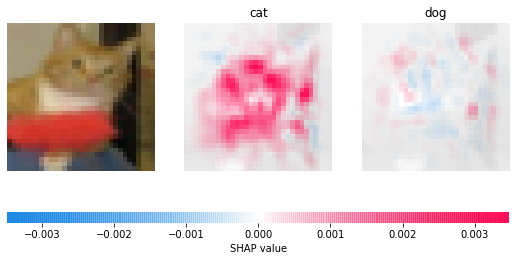

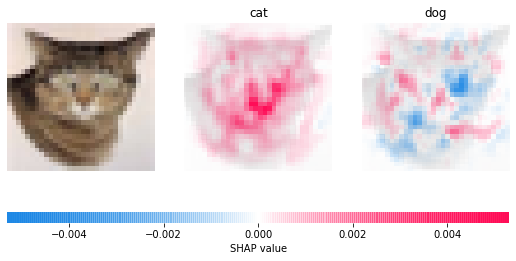

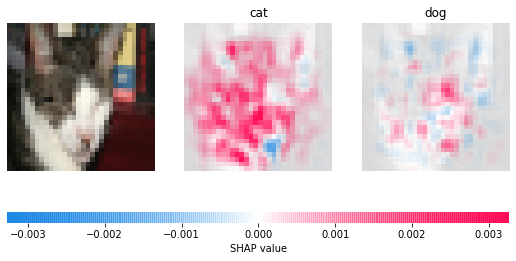

In [306]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [cat_class, dog_class], samples, True)

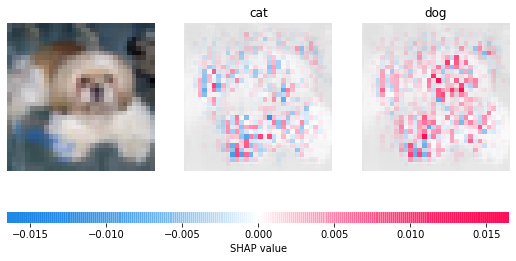

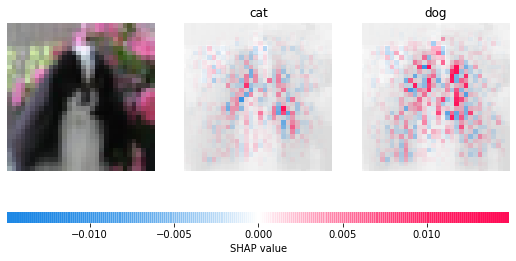

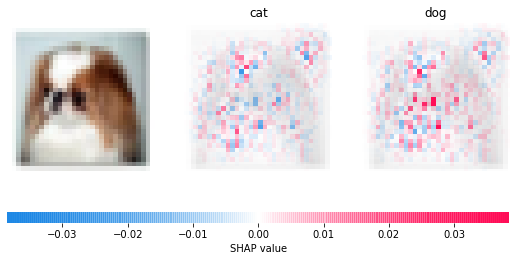

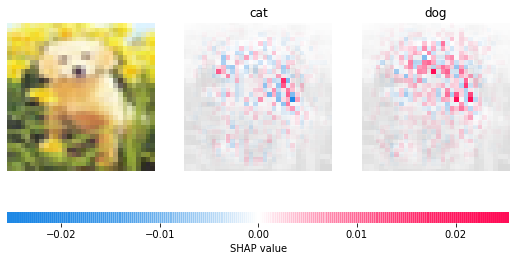

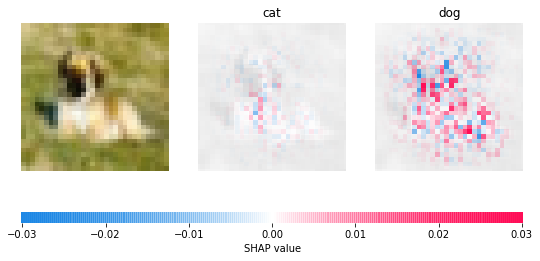

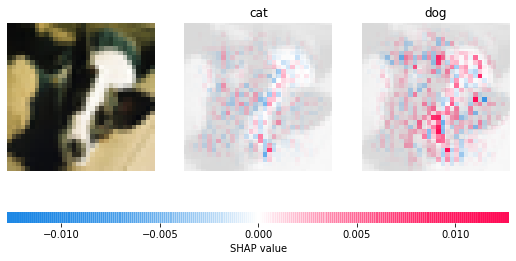

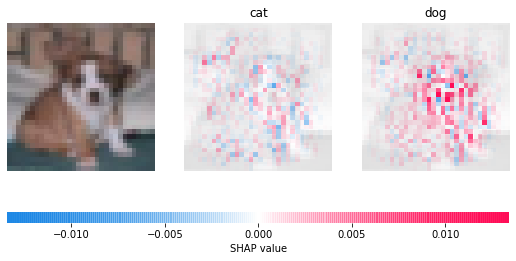

In [307]:
indices = dog_indices
samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [cat_class, dog_class], samples, True)

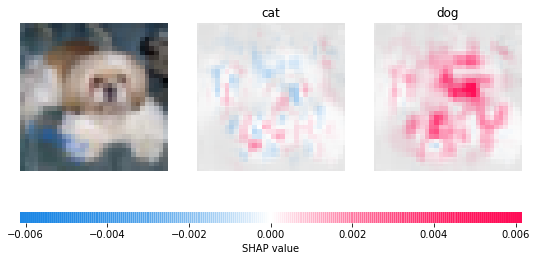

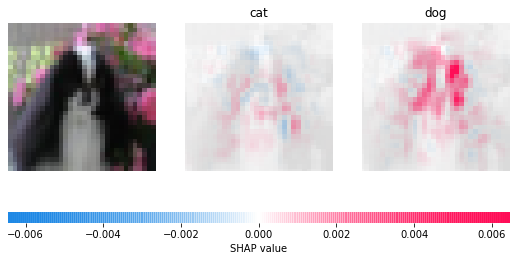

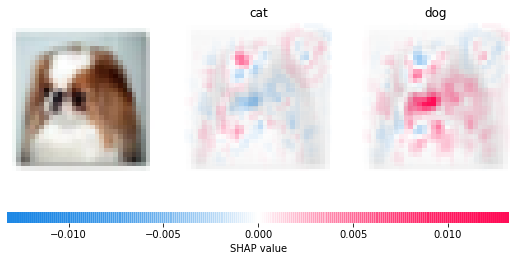

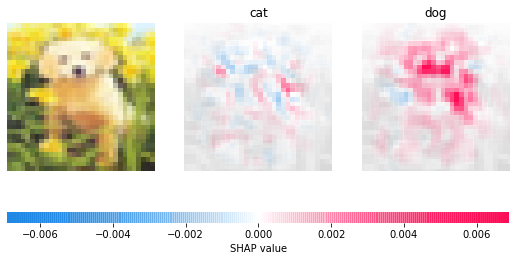

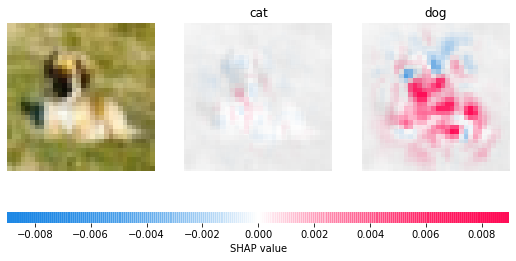

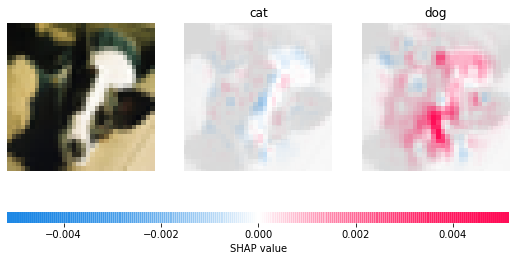

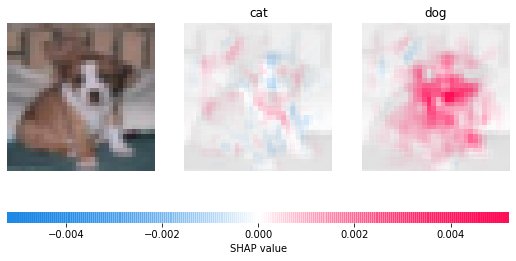

In [308]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [cat_class, dog_class], samples, True)

Większość zdjęć nie dała czytelnych rezultatów po przetworzeniu przez explainer. Po selekcji próbek, na których dało się zobaczyć obszary decydujące o predykcji modelu, doszliśmy do wniosku, że głównym kryterium, po którym model rozróżnia koty od psów, jest kształt ich pyska. W przypadku kotów często czerwonym kolorem podkreślone są krótkie podbródki i charakterystyczne nosy. W przypadku psów przeważnie obszarem decydującym był cały pysk.

## Analiza Shap values: konie vs jelenie

In [326]:
deer_class = 4
horse_class = 7

# recznie wybrane przyklady
deer_indices = [22, 36, 40, 117, 159, 227, 505]
horse_indices = [13, 17, 83, 109, 210, 216, 506]

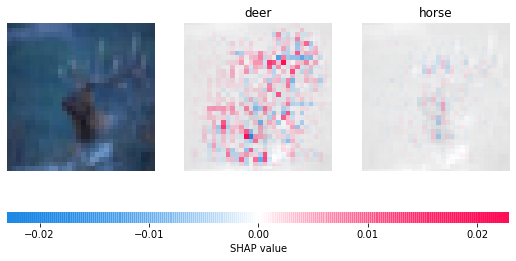

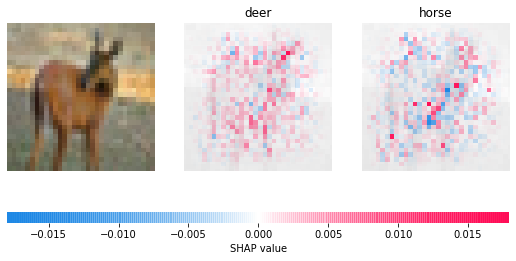

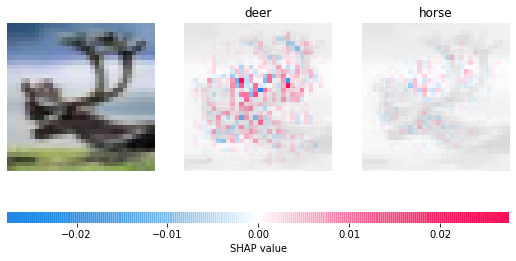

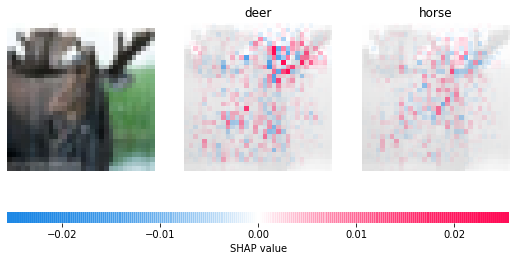

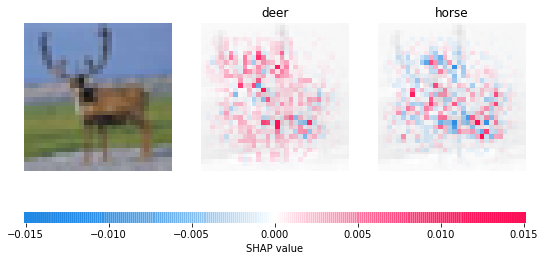

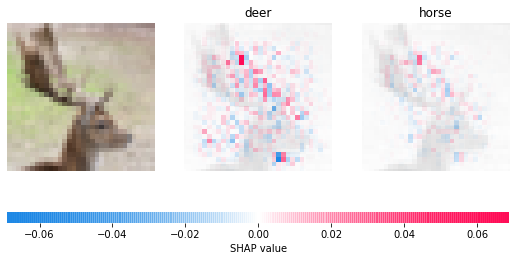

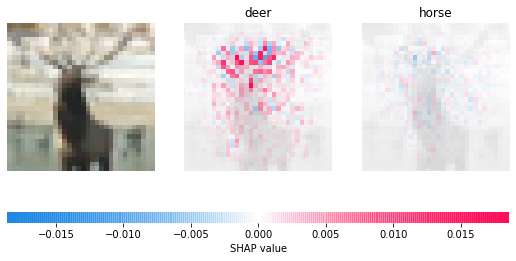

In [327]:
indices = deer_indices

samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [deer_class, horse_class], samples, True)

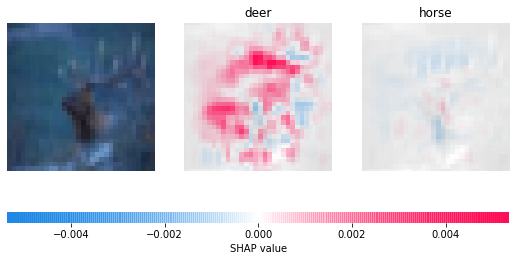

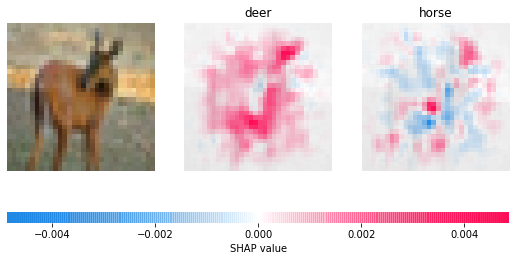

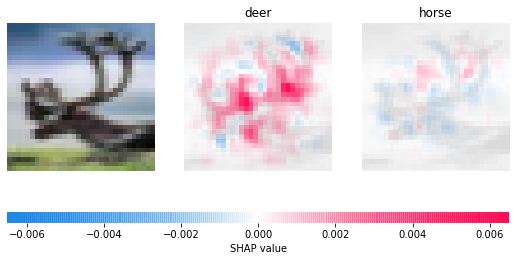

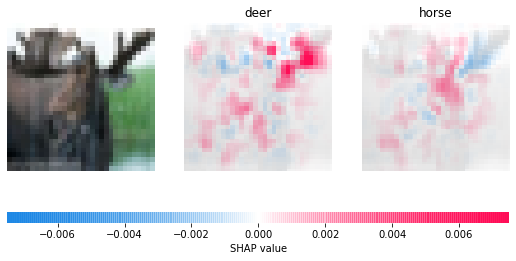

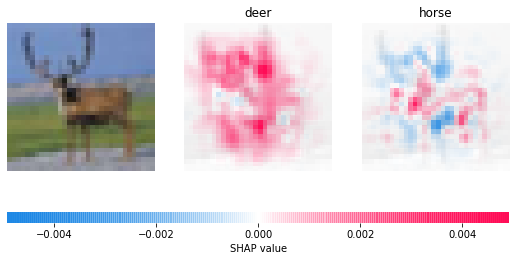

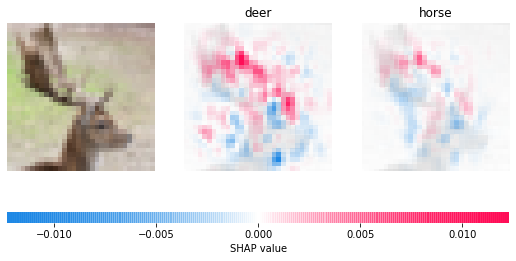

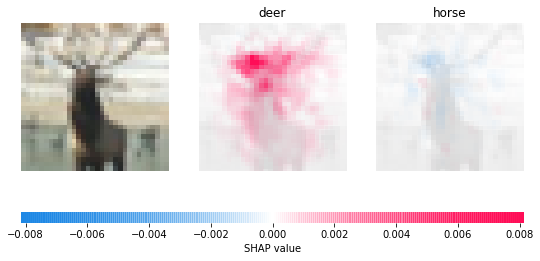

In [328]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [deer_class, horse_class], samples, True)

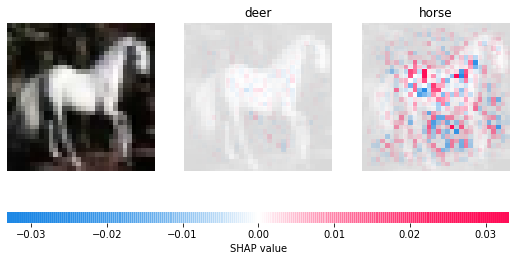

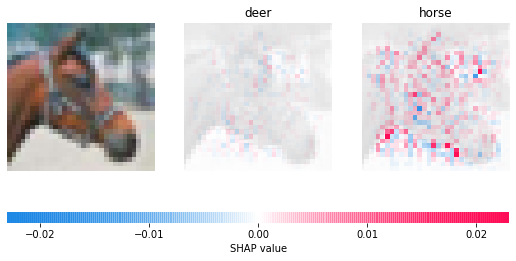

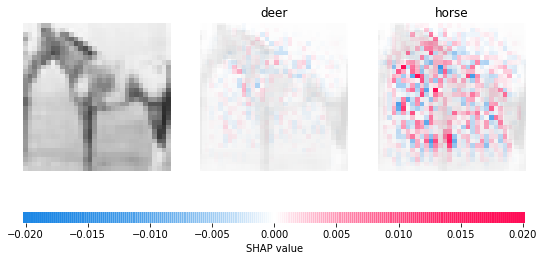

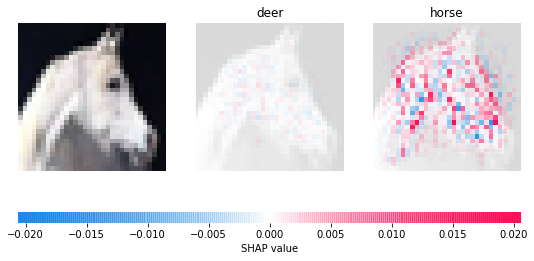

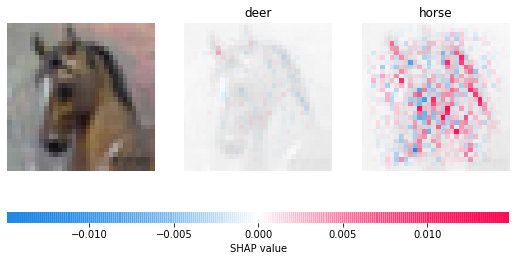

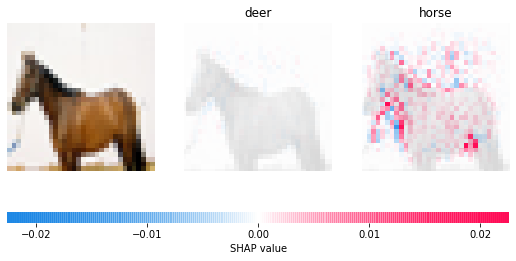

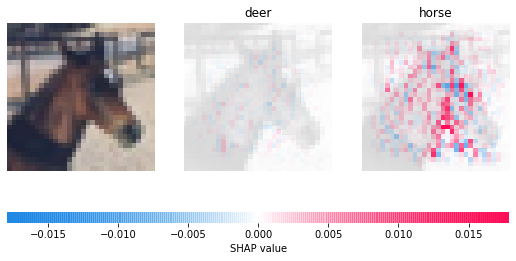

In [330]:
indices = horse_indices


samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [deer_class, horse_class], samples, True)

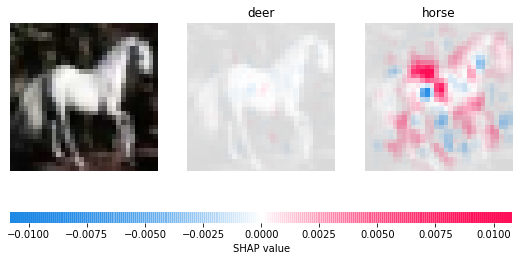

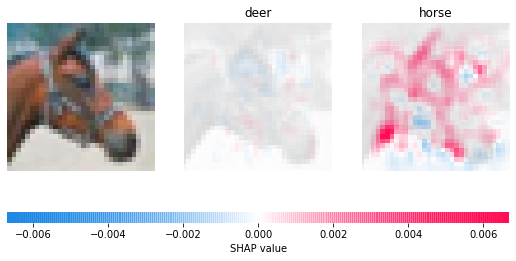

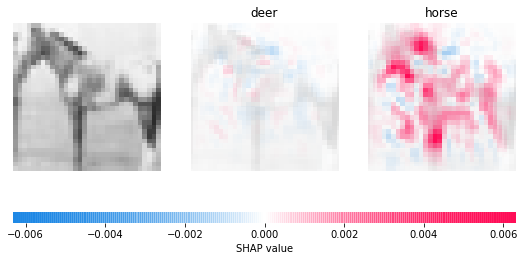

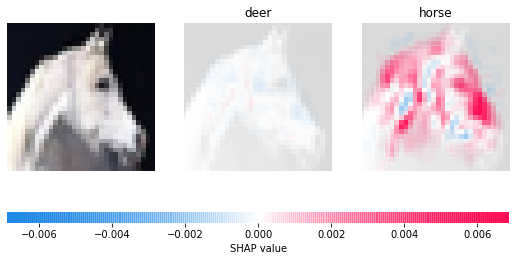

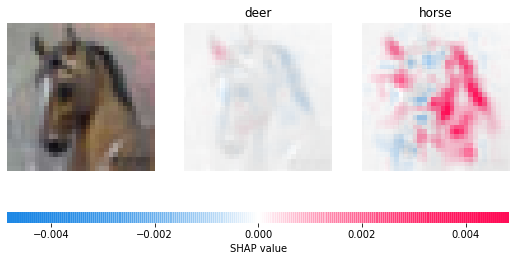

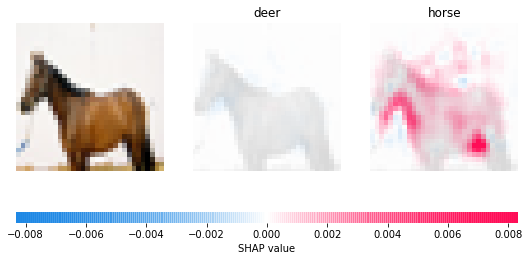

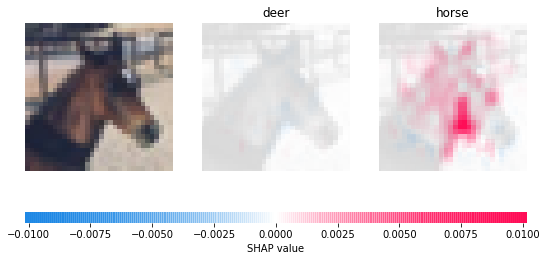

In [331]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [deer_class, horse_class], samples, True)

Zgodnie z oczekiwaniami, w przypadku rozróżniania jeleni kluczowe jest poroże. Bardzo ładnie jest to widoczne na większości zdjęć, gdy dla klasy jelenia poroże zaznaczone jest intensywnym czerwonym kolorem, natomiast dla klasy konia obszar poroża to kolor mocno niebieski. Charakterystyczne dla koni w większości przypadków są natomiast grzywy oraz szyje i żuchwa. Zdarza się również, że mocnym czerwonym kolorem zaznaczony jest jeździec na koniu.

Zadania dla studentów XD:

1) uzupełnianka kodu (wykorzystanie metody) - kod z explainowaniem kilku losowo wybranych probek

2) znajdz przynajmniej jedna pare klas, ktore sa ze soba mylone (albo przy pomocy pca, albo przy pomocy confusion matrix). znajdz kilka przykladow probek z kazdej klasy, dla ktorych shap dobrze pokazuje decydujace obszary zdjecia (w badaniu rezultatow moze pomoc zaaplikowanie rozmycia gaussowskiego, sprawdz wyniki dla roznego parametru sigma).

3) przetestuj dzialanie shap dla probek wyznazonych zgodnie z nastepujacymi zasadami:

- probki, ktore zostaly poprawnie sklasyfikowane przez model z najwieksza pewnoscia
- probki, ktore zostaly zupelnie sklasyfikowane z wysoka pewnoscia do zlej klasy
- probki, dla ktorych model waha sie pomiedzy dwoma klasami (predykcje dla obu klas zblizone do 50%)

sprawdz, czy shap pozwala zidentyfikowac problematyczne obszary na zdjeciu. (odp: nie)

4) [dodatkowe] sprobuj zinterpretowac wybrane probki przy uzyciu kernel explainera. 

## Selekcja próbek, dla których predykcja modelu jest wyrównana dla dwóch klas

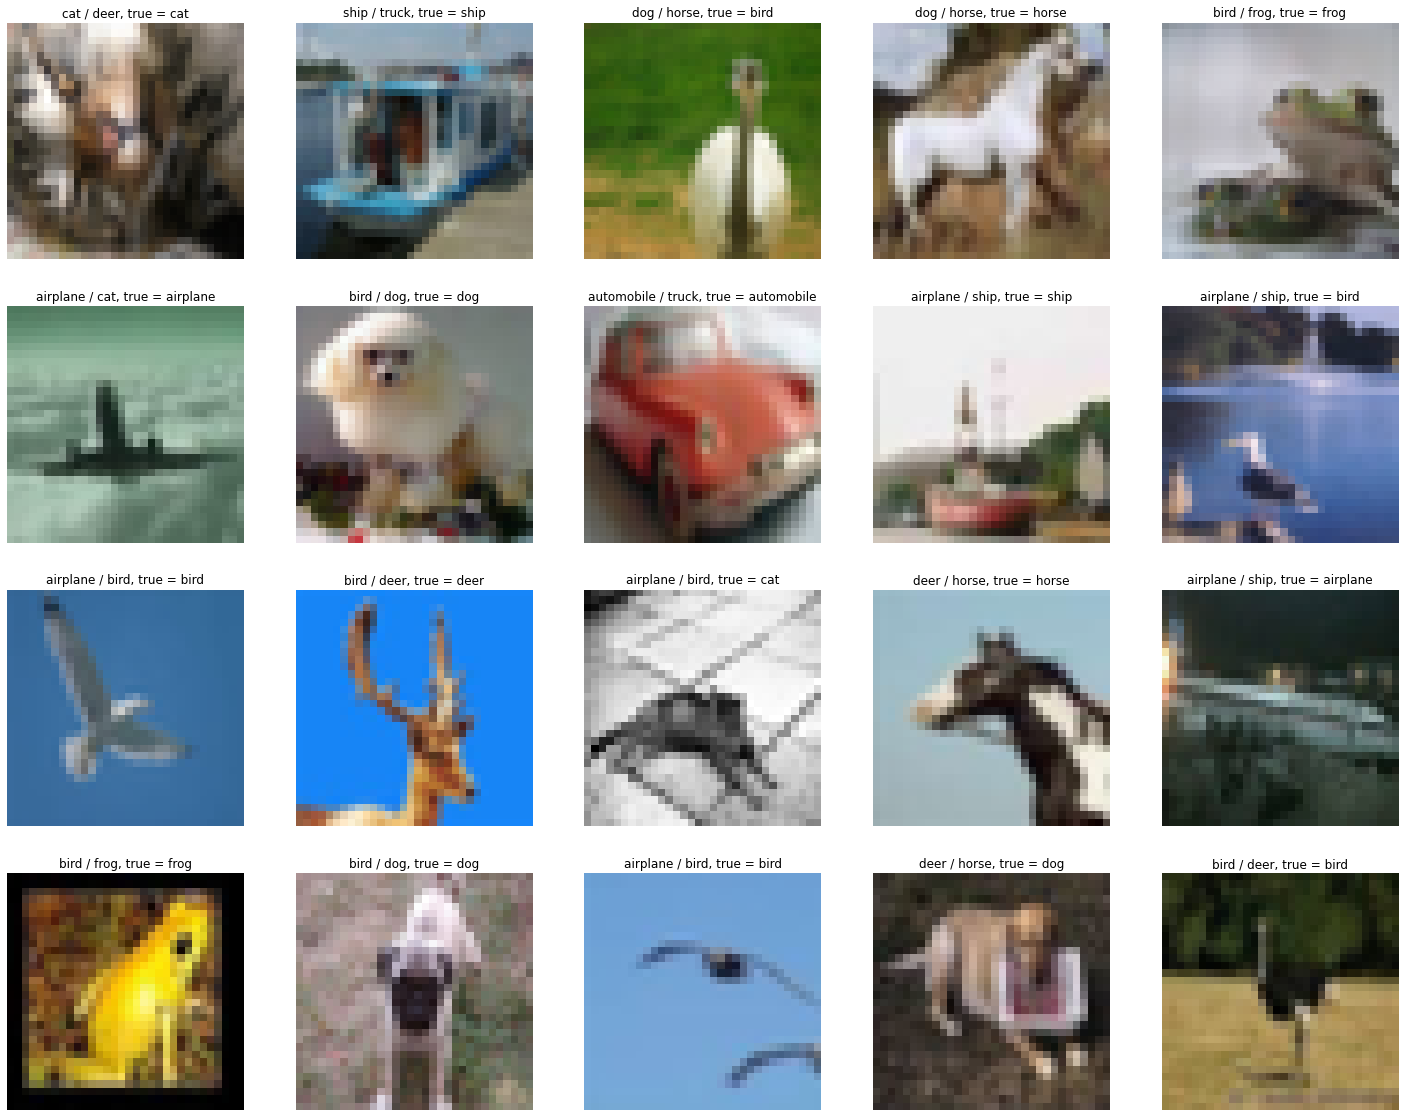

In [116]:
CONFUSING_SAMPLES_COUNT = 20
CONFIDENCE_THRESHOLD = 0.4

preds_above_threshold = test_preds > CONFIDENCE_THRESHOLD
confusing_preds_mask = np.sum(preds_above_threshold, axis=-1) > 1
confusing_samples_indices = np.argwhere(confusing_preds_mask)[:CONFUSING_SAMPLES_COUNT].flatten()
confusing_samples_preds = [np.argwhere(preds_above_threshold[i]).flatten() for i in confusing_samples_indices]

plt.figure(figsize=(25, 20))
for i, (sample_index, sample_preds) in enumerate(zip(confusing_samples_indices, confusing_samples_preds)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[sample_index])
    plt.title(f'{class_names[sample_preds[0]]} / {class_names[sample_preds[1]]},' + \
              f' true = {class_names[y_test[sample_index][0]]}')
    plt.axis('off')

Explained Shapley values for sample 0


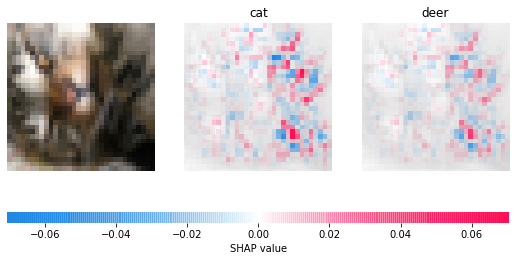

Explained Shapley values for sample 0


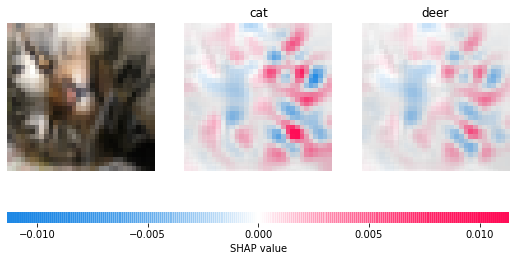

Explained Shapley values for sample 0


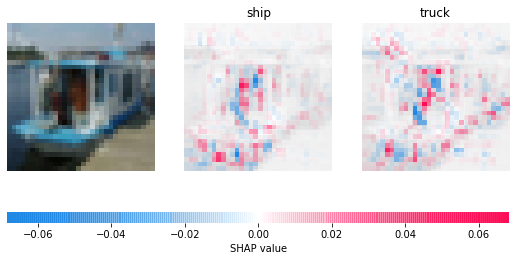

Explained Shapley values for sample 0


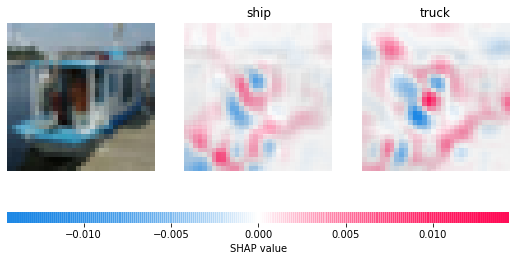

Explained Shapley values for sample 0


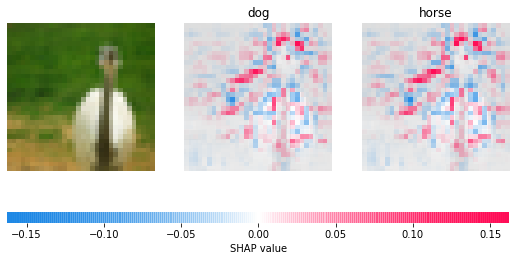

Explained Shapley values for sample 0


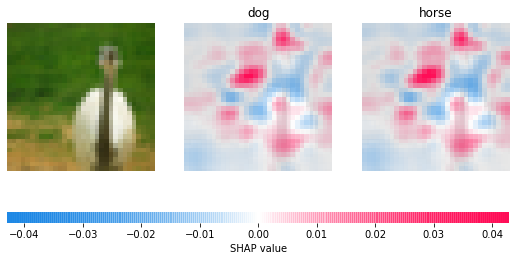

Explained Shapley values for sample 0


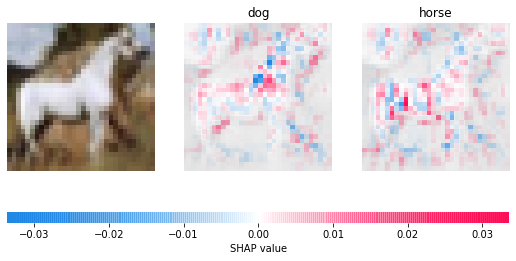

Explained Shapley values for sample 0


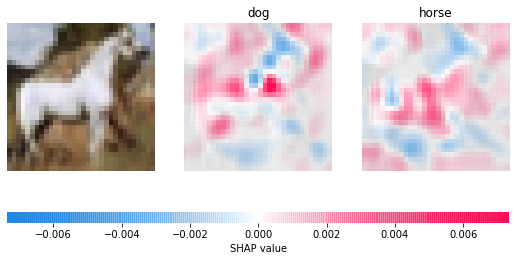

Explained Shapley values for sample 0


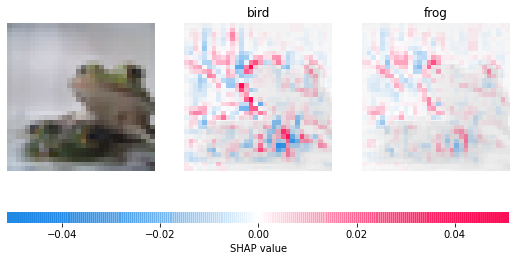

Explained Shapley values for sample 0


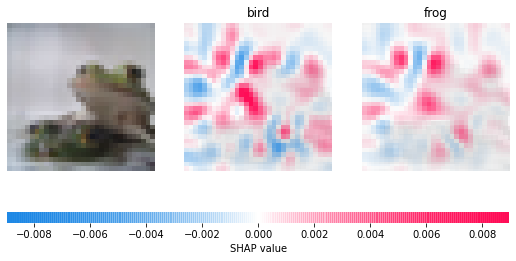

Explained Shapley values for sample 0


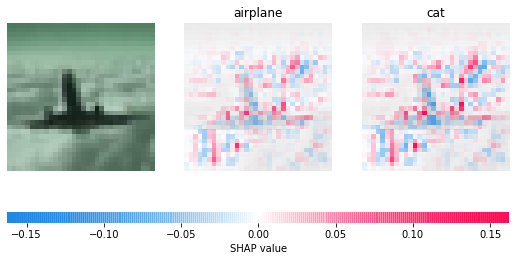

Explained Shapley values for sample 0


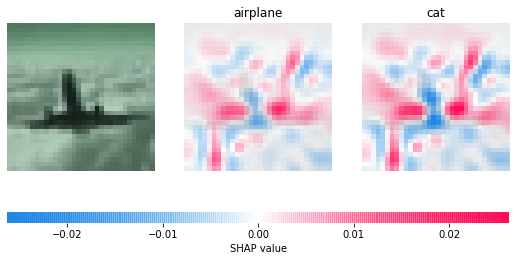

Explained Shapley values for sample 0


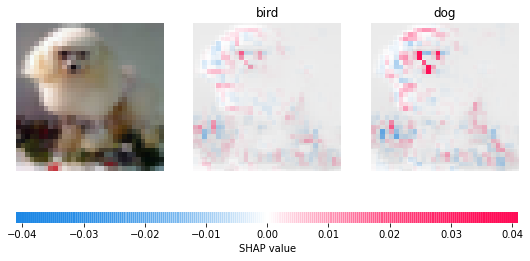

Explained Shapley values for sample 0


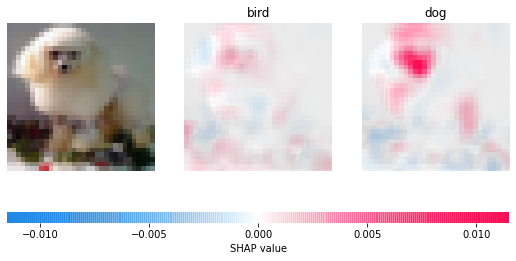

Explained Shapley values for sample 0


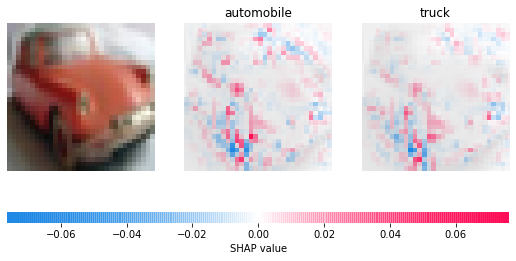

Explained Shapley values for sample 0


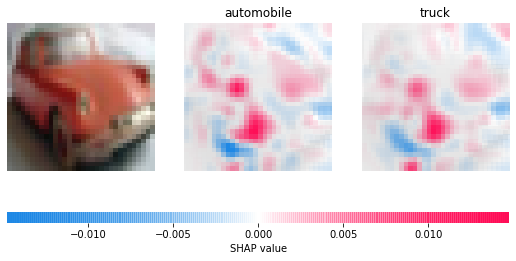

Explained Shapley values for sample 0


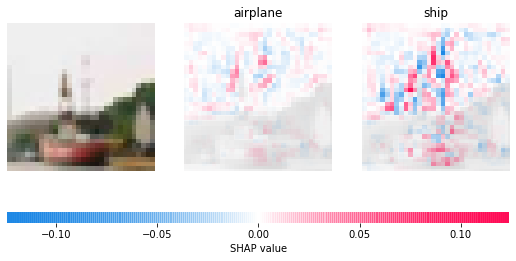

Explained Shapley values for sample 0


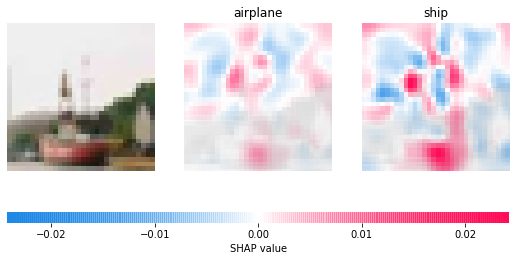

Explained Shapley values for sample 0


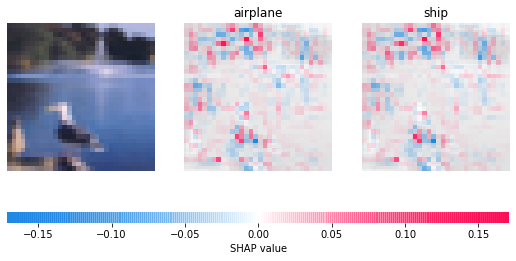

Explained Shapley values for sample 0


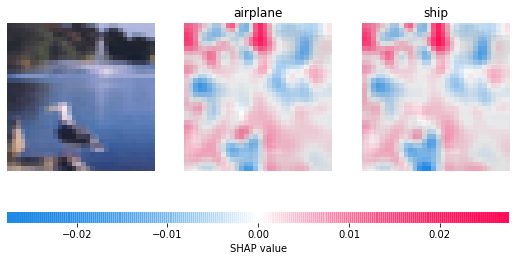

Explained Shapley values for sample 0


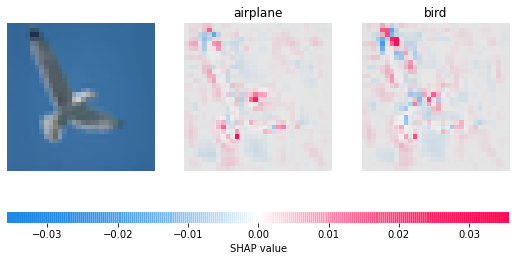

Explained Shapley values for sample 0


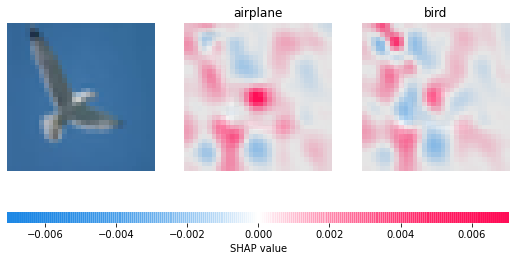

Explained Shapley values for sample 0


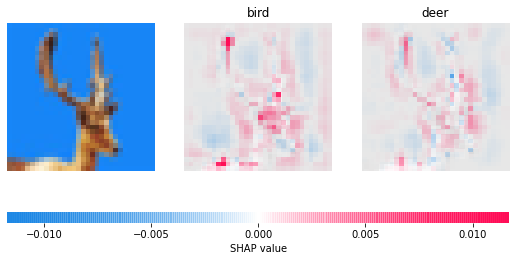

Explained Shapley values for sample 0


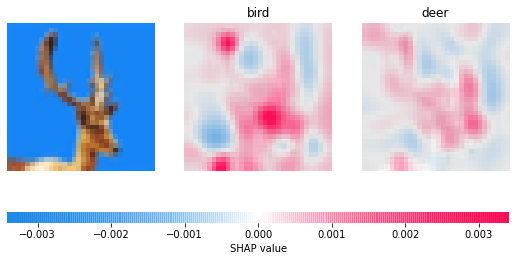

Explained Shapley values for sample 0


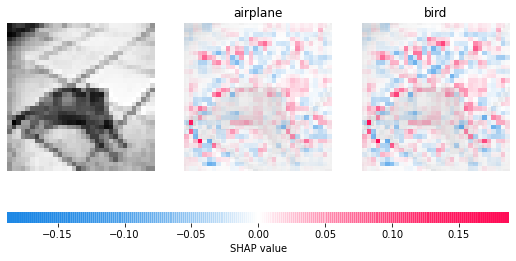

Explained Shapley values for sample 0


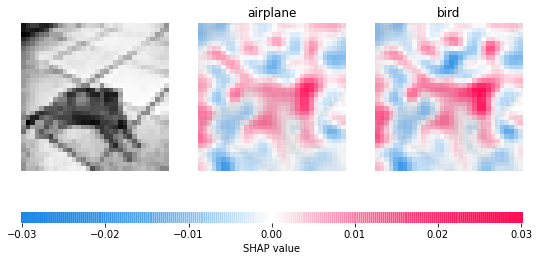

Explained Shapley values for sample 0


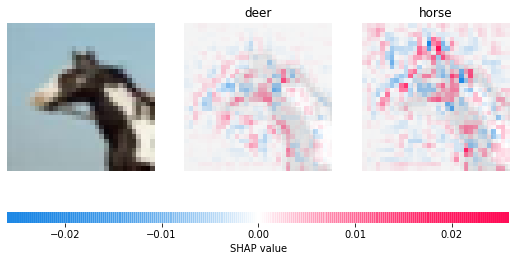

Explained Shapley values for sample 0


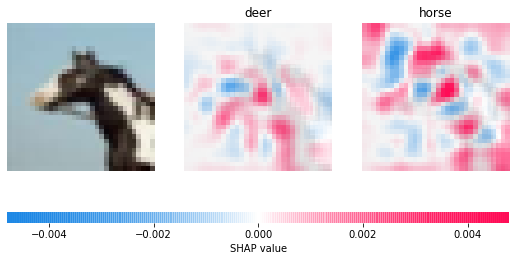

Explained Shapley values for sample 0


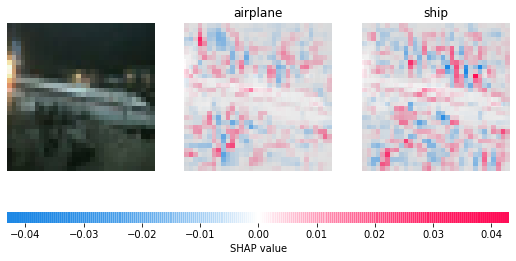

Explained Shapley values for sample 0


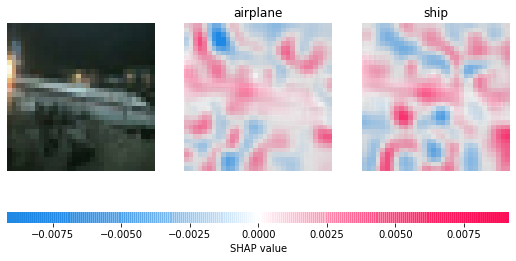

Explained Shapley values for sample 0


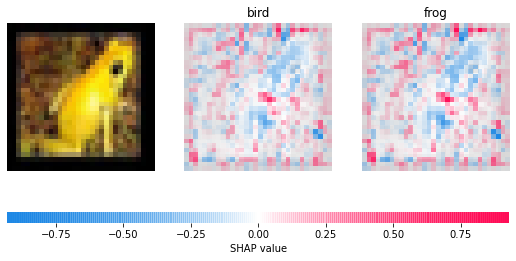

Explained Shapley values for sample 0


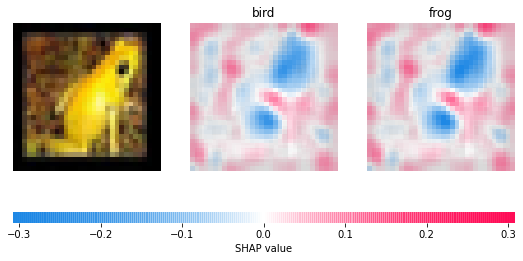

Explained Shapley values for sample 0


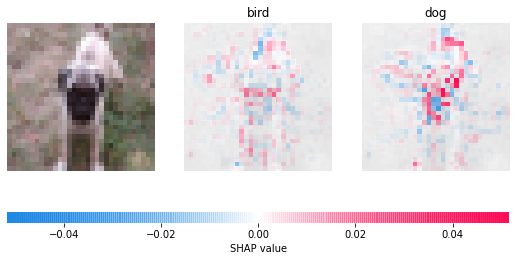

Explained Shapley values for sample 0


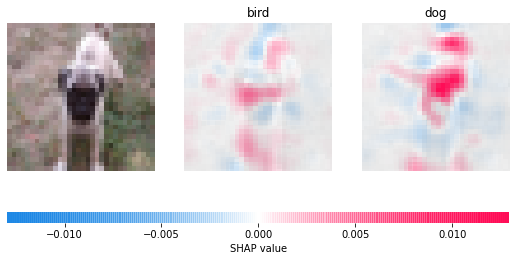

Explained Shapley values for sample 0


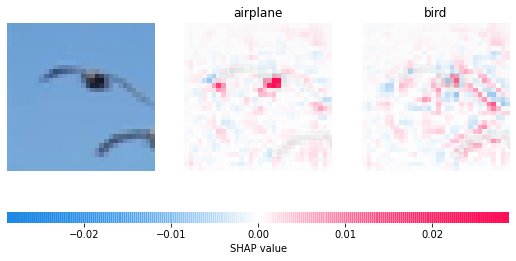

Explained Shapley values for sample 0


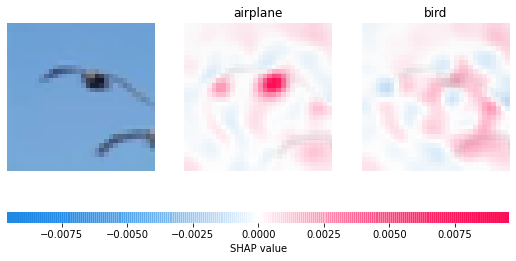

Explained Shapley values for sample 0


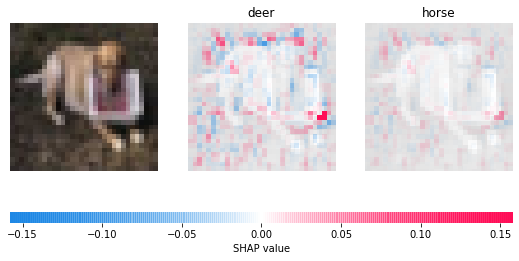

Explained Shapley values for sample 0


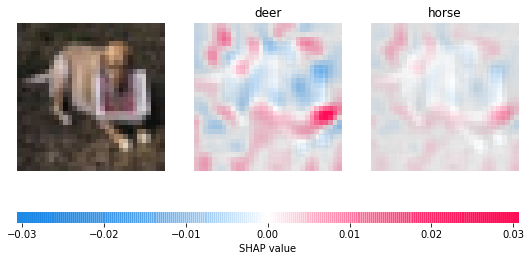

Explained Shapley values for sample 0


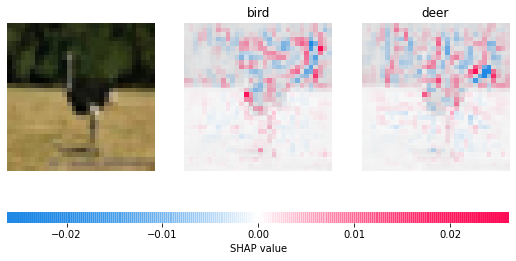

Explained Shapley values for sample 0


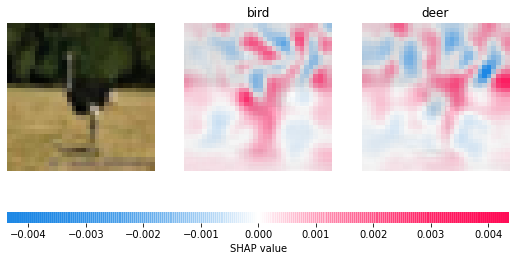

In [125]:
# wizualizacja najgorszych probek - zestawienie predykcji z prawidlowa klasa

for sample_index, predicted_classes in zip(confusing_samples_indices, confusing_samples_preds):
    img = X_test[sample_index]
    img_prep = X_test_prep[sample_index]
    true_label = y_test[sample_index]
        
    shap_values = explainer.shap_values(np.array([img_prep]))
    shap_values_blurred = blur_shap_values(shap_values, gaussian_blur_sigma=1.5)
    
    plot_shap_values(
        shap_values,
        classes_indices_to_explain=predicted_classes,
        samples_to_plot=[0],
        images=np.array([img / 255.]),
        class_names=class_names
    )
    
    plot_shap_values(
        shap_values_blurred,
        classes_indices_to_explain=predicted_classes,
        samples_to_plot=[0],
        images=np.array([img / 255.]),
        class_names=class_names
    )
    
    
# imgs = X_test[worst_samples_indices[class_index]]

# for i, sample_index in enumerate(worst_samples_indices[class_index]):
#     true_class = y_test[sample_index][0]
#     pred_class = test_preds_classes[sample_index]
    
#     shap_values = worst_samples_shap[class_index]
#     shap_values_blurred = blur_shap_values(shap_values, gaussian_blur_sigma=1.5)
    
#     plot_shap_values(shap_values=shap_values,
#                      classes_indices_to_explain=[pred_class, true_class],
#                      samples_to_plot=[i], 
#                      images=imgs / 255,
#                      class_names=class_names)
    
#     plot_shap_values(shap_values=shap_values_blurred,
#                      classes_indices_to_explain=[pred_class, true_class],
#                      samples_to_plot=[i], 
#                      images=imgs / 255,
#                      class_names=class_names)

## Selekcja przykładowych próbek

In [36]:
# wybieranie najlepiej i najgorzej zaklasyfikowanych próbek z każdej klasy dla zbioru testowego


SAMPLES_PER_CLASS = 5

best_samples_indices = []
worst_samples_indices = []

for class_index in range(10):
    class_mask = y_test.flatten() == class_index
    class_preds = test_preds[:, class_index]
    indices = range(len(class_preds))
    
    best_preds_sorted = sorted(zip(class_preds * class_mask, indices), reverse=True)
    best_selected_indices = [i[1] for i in best_preds_sorted]
    best_samples_indices.append(best_selected_indices[:SAMPLES_PER_CLASS])
    
    worst_preds_sorted = sorted(zip((1 - class_preds) * class_mask, indices), reverse=True)
    worst_selected_indices = [i[1] for i in worst_preds_sorted]
    worst_samples_indices.append(worst_selected_indices[:SAMPLES_PER_CLASS])

best selected samples


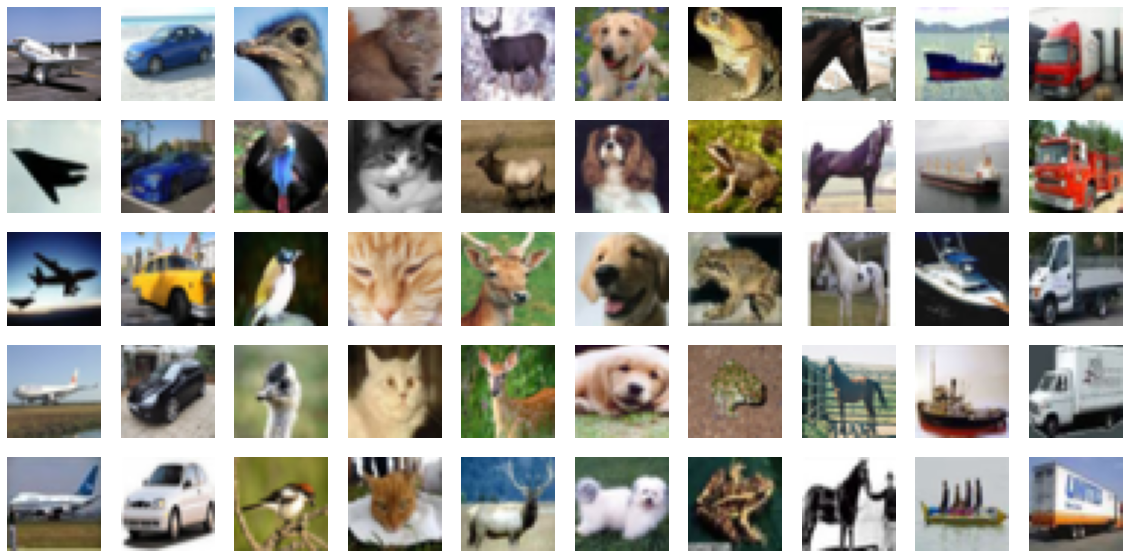

In [45]:
print('best selected samples')
plt.figure(figsize=(20, 10))
for class_index, img_indices in enumerate(best_samples_indices):
    for sample_index, img_index in enumerate(img_indices):
        plt.subplot(SAMPLES_PER_CLASS, 10, sample_index * 10 + class_index + 1)
        plt.axis('off')
        plt.imshow(X_test[img_index])

worst selected samples


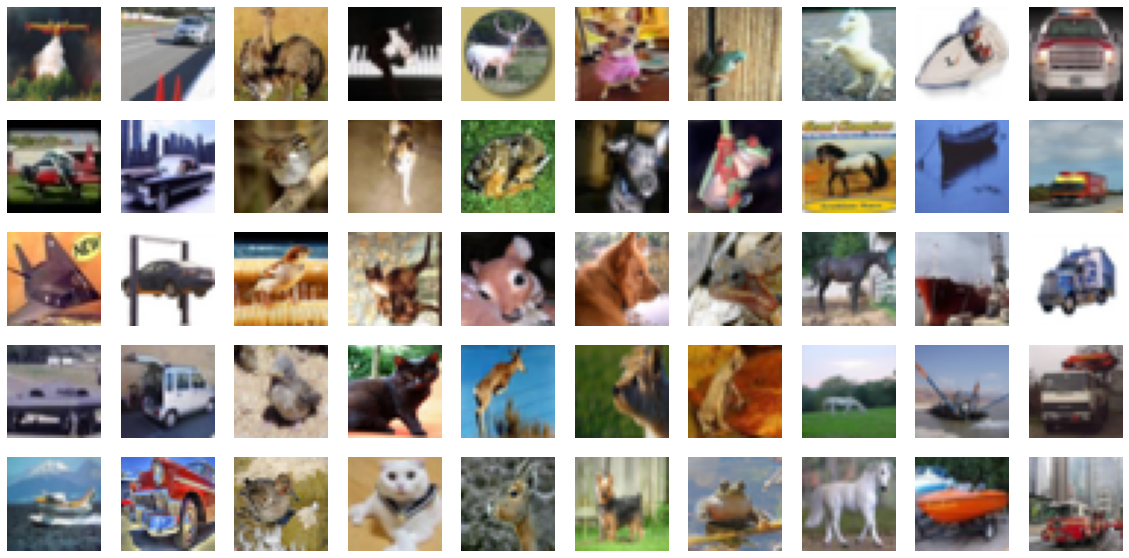

In [46]:
print('worst selected samples')
plt.figure(figsize=(20, 10))
for class_index, img_indices in enumerate(worst_samples_indices):
    for sample_index, img_index in enumerate(img_indices):
        plt.subplot(SAMPLES_PER_CLASS, 10, sample_index * 10 + class_index + 1)
        plt.axis('off')
        plt.imshow(X_test[img_index])

## Selekcja próbek, dla których predykcja modelu jest wyrównana dla dwóch klas

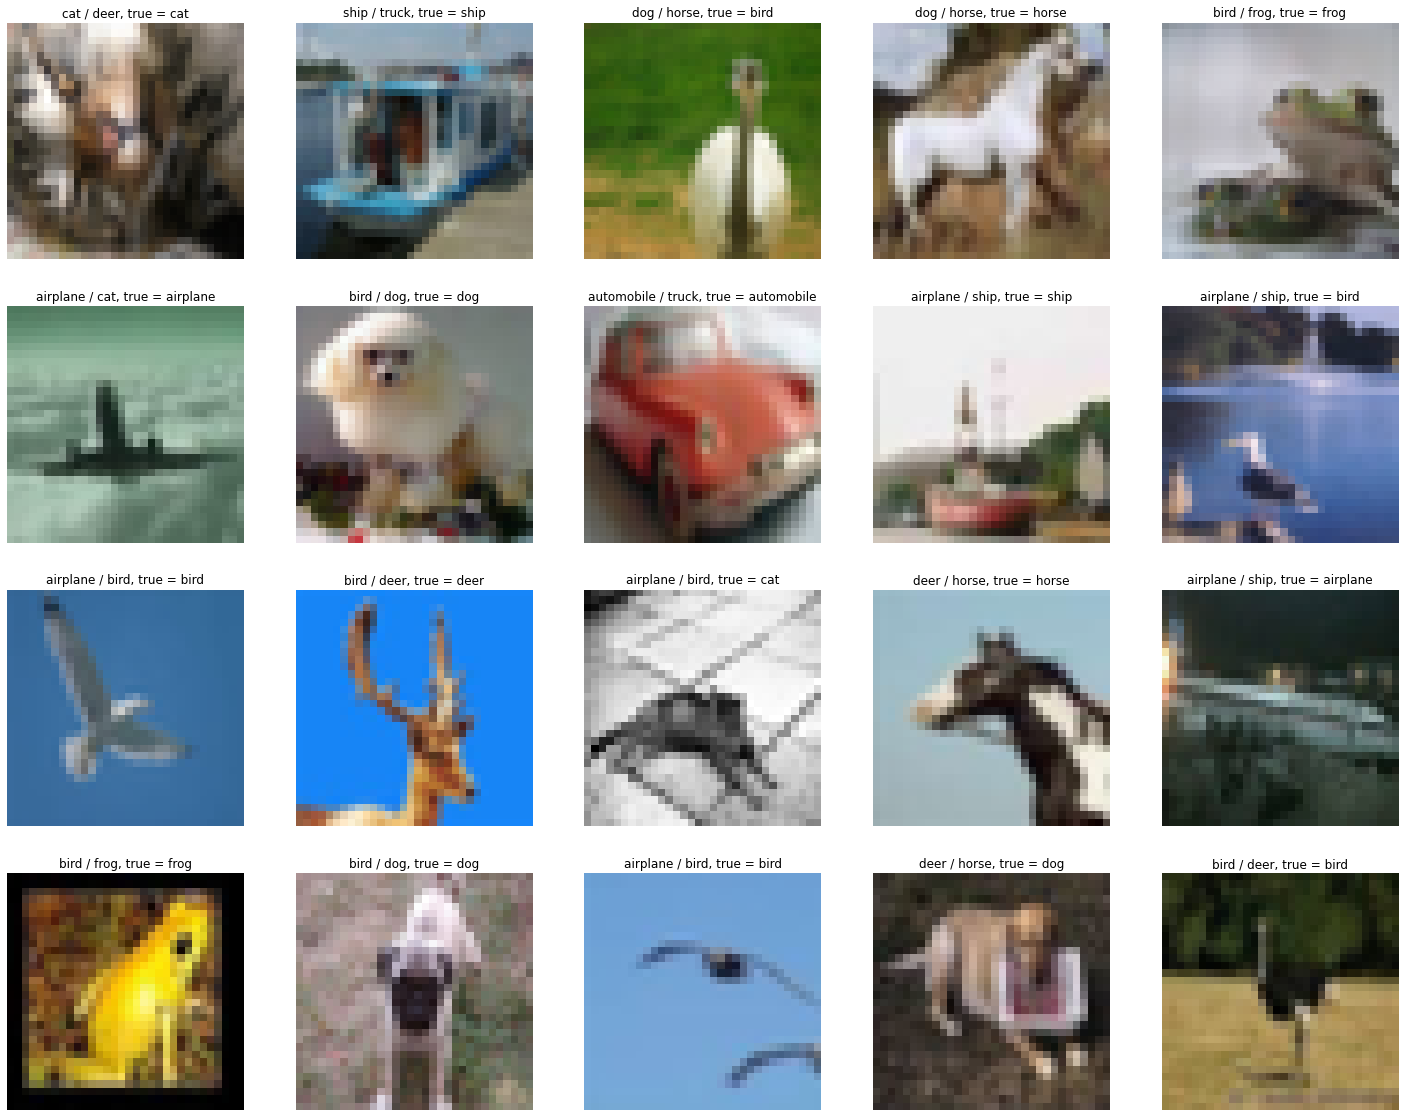

In [114]:
CONFUSING_SAMPLES_COUNT = 20
CONFIDENCE_THRESHOLD = 0.4

preds_above_threshold = test_preds > CONFIDENCE_THRESHOLD
confusing_preds_mask = np.sum(preds_above_threshold, axis=-1) > 1
confusing_samples_indices = np.argwhere(confusing_preds_mask)[:CONFUSING_SAMPLES_COUNT].flatten()
confusing_samples_preds = [np.argwhere(preds_above_threshold[i]).flatten() for i in confusing_samples_indices]

plt.figure(figsize=(25, 20))
for i, (sample_index, sample_preds) in enumerate(zip(confusing_samples_indices, confusing_samples_preds)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[sample_index])
    plt.title(f'{class_names[sample_preds[0]]} / {class_names[sample_preds[1]]},' + \
              f' true = {class_names[y_test[sample_index][0]]}')
    plt.axis('off')

## Wyjaśnienie próbek za pomocą DeepExplainer'a

In [64]:
%%time
# background = np.zeros((1, 32, 32, 3))
# background = X_train_prep[np.random.choice(X_train_prep.shape[0], 200, replace=False)]
background = np.mean(X_train_prep.reshape(-1, 32 * 32 * 3), axis=0).reshape(1, 32, 32, 3)
explainer = shap.DeepExplainer(model, background)

best_samples_shap = []
for class_index, samples_indices in tqdm(enumerate(best_samples_indices)):
    batch = X_test_prep[samples_indices]
    batch_shap = explainer.shap_values(batch)
    best_samples_shap.append(batch_shap)

worst_samples_shap = []
for class_index, samples_indices in tqdm(enumerate(worst_samples_indices)):
    batch = X_test_prep[samples_indices]
    batch_shap = explainer.shap_values(batch)
    worst_samples_shap.append(batch_shap)

10it [02:38, 15.88s/it]
10it [02:18, 13.89s/it]

CPU times: user 8min 51s, sys: 10.9 s, total: 9min 2s
Wall time: 4min 58s


In [ ]:
worst_samples_shap = []
for class_index, samples_indices in tqdm(enumerate(worst_samples_indices)):
    batch = X_test_prep[samples_indices]
    batch_shap = explainer.shap_values(batch)
    worst_samples_shap.append(batch_shap)

Explained Shapley values for sample 0


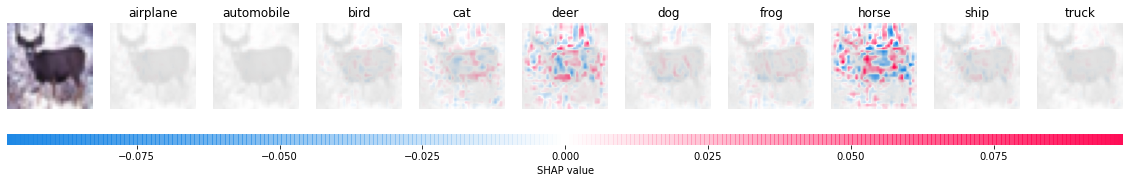

Explained Shapley values for sample 1


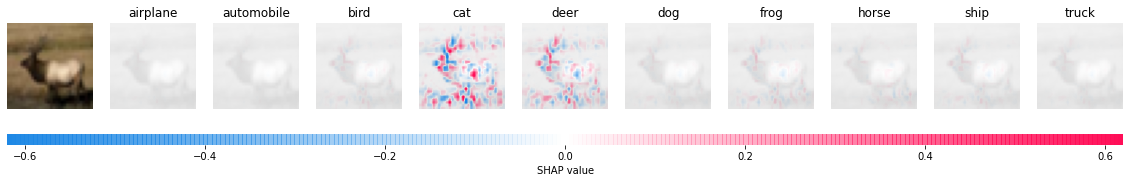

Explained Shapley values for sample 2


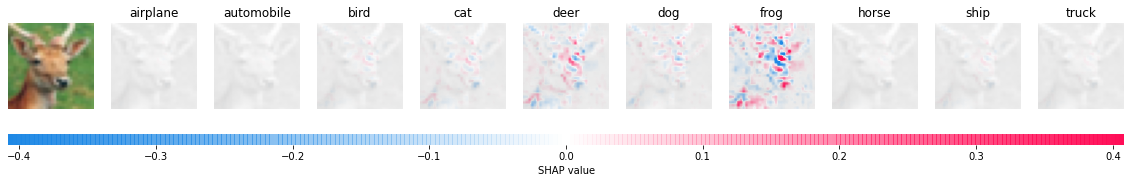

Explained Shapley values for sample 3


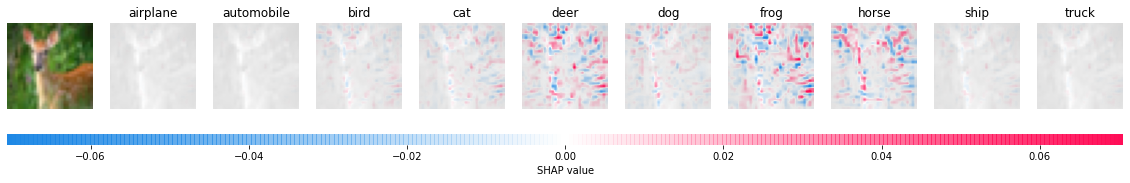

Explained Shapley values for sample 4


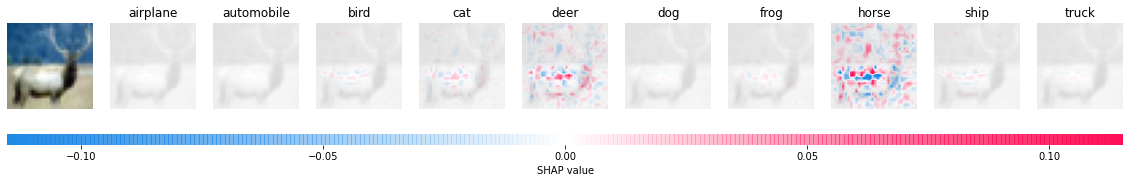

In [77]:
class_index = 4

plot_shap_values(shap_values=best_samples_shap[class_index],
                 classes_indices_to_explain=range(10),
                 samples_to_plot=[0, 1, 2, 3, 4], 
                 images=X_test[best_samples_indices[class_index]] / 255,
                 class_names=class_names)

Explained Shapley values for sample 0


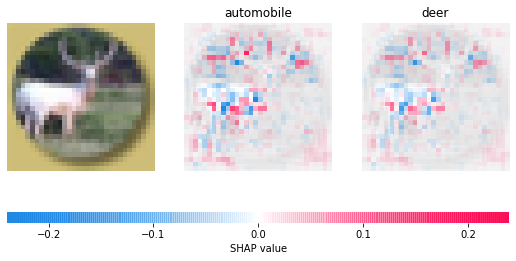

Explained Shapley values for sample 0


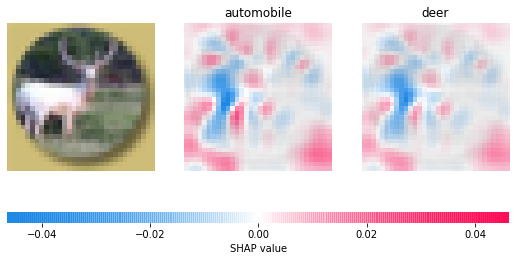

Explained Shapley values for sample 1


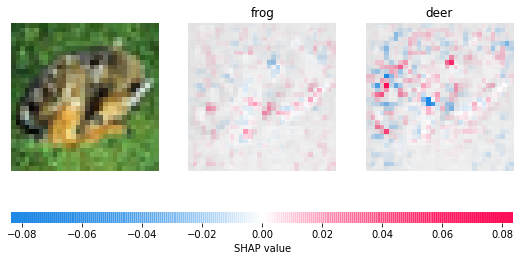

Explained Shapley values for sample 1


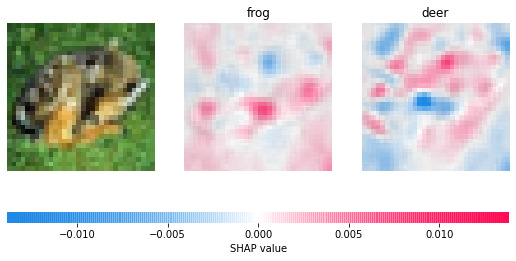

Explained Shapley values for sample 2


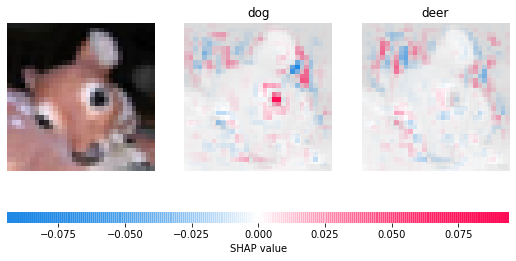

Explained Shapley values for sample 2


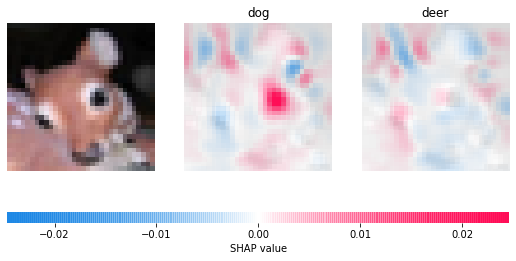

Explained Shapley values for sample 3


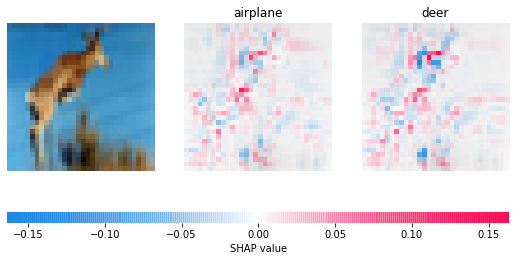

Explained Shapley values for sample 3


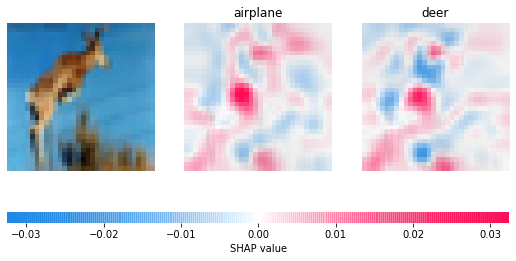

Explained Shapley values for sample 4


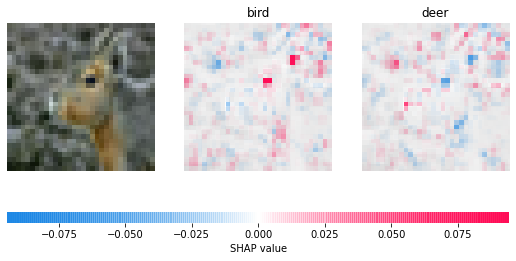

Explained Shapley values for sample 4


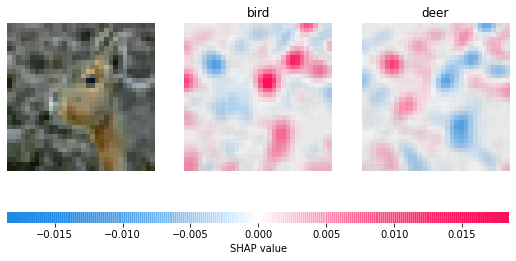

In [89]:
# wizualizacja najgorszych probek - zestawienie predykcji z prawidlowa klasa

class_index = 4
imgs = X_test[worst_samples_indices[class_index]]

for i, sample_index in enumerate(worst_samples_indices[class_index]):
    true_class = y_test[sample_index][0]
    pred_class = test_preds_classes[sample_index]
    
    shap_values = worst_samples_shap[class_index]
    shap_values_blurred = blur_shap_values(shap_values, gaussian_blur_sigma=1.5)
    
    plot_shap_values(shap_values=shap_values,
                     classes_indices_to_explain=[pred_class, true_class],
                     samples_to_plot=[i], 
                     images=imgs / 255,
                     class_names=class_names)
    
    plot_shap_values(shap_values=shap_values_blurred,
                     classes_indices_to_explain=[pred_class, true_class],
                     samples_to_plot=[i], 
                     images=imgs / 255,
                     class_names=class_names)

## Znalezienie najciekawszych próbek

Spośród wybranych losowo próbek znajdujemy te, których klasyfikacja była trudna dla modelu oraz te, które posiadają bardzo wysokie i/lub niskie wartości Shapley'a.

In [ ]:
# todo: losowanie sampli

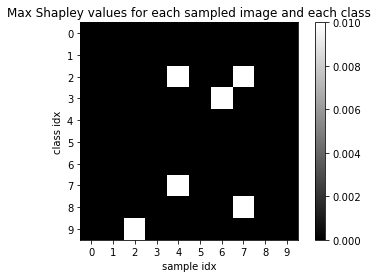

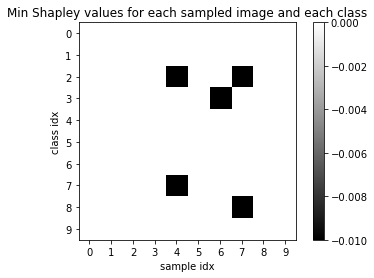

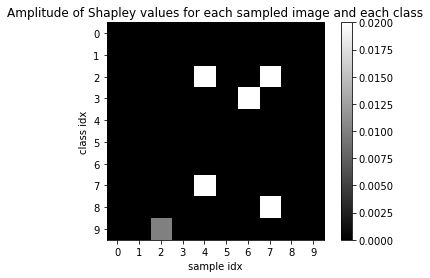

In [85]:
maxes = np_shap.reshape((*np_shap.shape[:2], -1)).max(axis=-1).round(2)
mins = np_shap.reshape((*np_shap.shape[:2], -1)).min(axis=-1).round(2)
amplitude = maxes - mins

def plot_stuff(array, title):
    plt.imshow(array, cmap='gray')
    plt.colorbar()
    plt.xticks(range(TEST_SAMPLES_COUNT))
    plt.xlabel('sample idx')
    plt.yticks(range(len(class_names)))
    plt.ylabel('class idx')
    plt.title(title)
    plt.show()

plot_stuff(maxes, 'Max Shapley values for each sampled image and each class')
plot_stuff(mins, 'Min Shapley values for each sampled image and each class')
plot_stuff(amplitude, 'Amplitude of Shapley values for each sampled image and each class')

## Demonstracja znalezionych wartości Shapley'a dla wybranych próbek

Explained Shapley values for sample 6


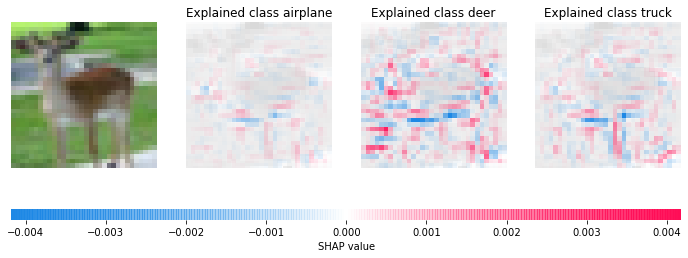

In [87]:
plot_shap_values(shap_values=shap_values,
                 classes_indices_to_explain=list(range(10)), 
                 samples_to_plot=list(range(SAMPLES_PER_CLASS)), 
                 images=images_to_explain,
                 class_names=class_names)

Explained Shapley values for sample 0


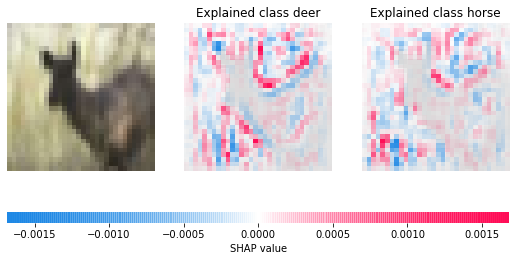

Explained Shapley values for sample 1


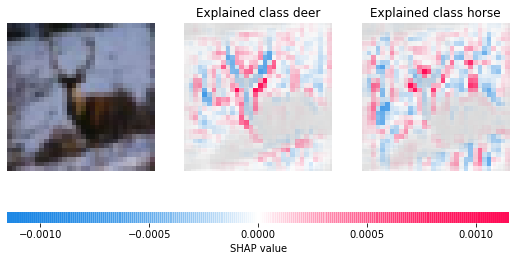

Explained Shapley values for sample 2


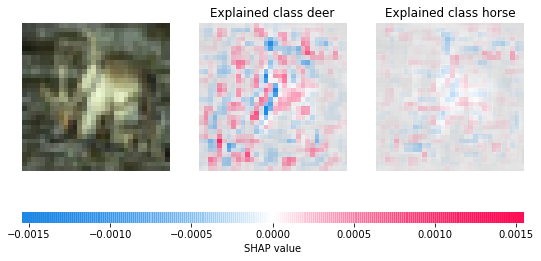

Explained Shapley values for sample 3


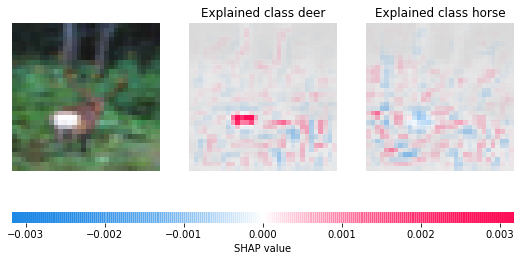

In [88]:
plot_shap_values(shap_values=shap_values,
                 classes_indices_to_explain=[4, 7], 
                 samples_to_plot=[0, 1, 2, 3], 
                 images=images_to_explain,
                 class_names=class_names)

## Aplikacja rozmycia gaussowskiego na znalezionych wartościach Shapley'a

W celu nieco bardziej intuicyjnej prezentacji działania Shap values aplikujemy na znalezione wartości rozmycie gaussowskie pozwalające łatwiej zauważyć, które części obrazu wpływają na predykcję

In [90]:
blurred_shap_values = blur_shap_values(shap_values, 1)

Explained Shapley values for sample 7


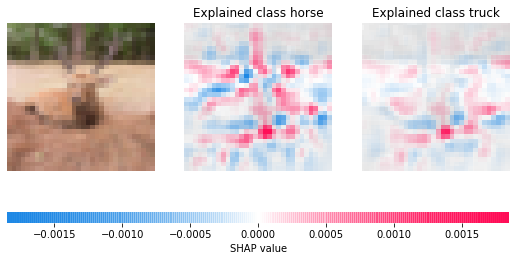

In [91]:
plot_shap_values(shap_values=blurred_shap_values,
                 classes_indices_to_explain=[7, 9], 
                 samples_to_plot=[7], 
                 images=images_to_explain,
                 class_names=class_names)

## KernelExplainer

In [105]:
def predict_wrapper(model):
    def wrapped(flat_input):
        return model.predict(flat_input.reshape(-1, 32, 32, 3))
    
    return wrapped

In [106]:
np.mean(X_train, axis=0).reshape(1, -1).shape

(1, 3072)

In [110]:
%%time
background = np.zeros((1, 32, 32, 3)).reshape(1, -1)
explainer = shap.KernelExplainer(predict_wrapper(model), background)
shap_values = explainer.shap_values(images_to_explain.reshape(-1, 32 * 32 * 3))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


CPU times: user 1h 54min 25s, sys: 24min 42s, total: 2h 19min 8s
Wall time: 35min 7s


In [113]:
shhh = np.array(shap_values).reshape((10, TEST_SAMPLES_COUNT, 32, 32, 3))

Explained Shapley values for sample 0


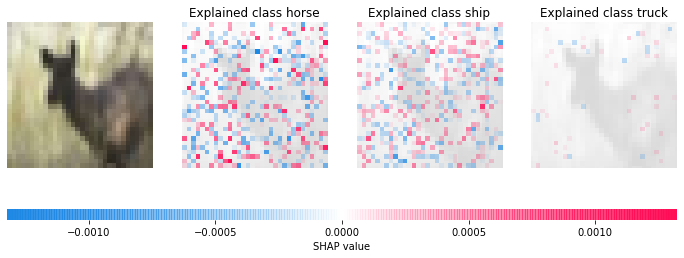

Explained Shapley values for sample 1


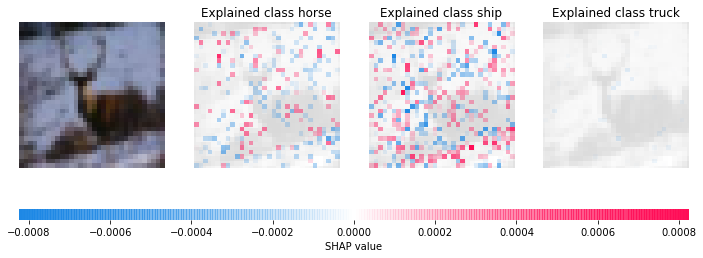

Explained Shapley values for sample 2


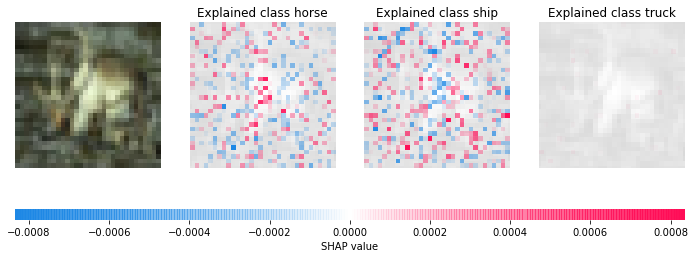

Explained Shapley values for sample 3


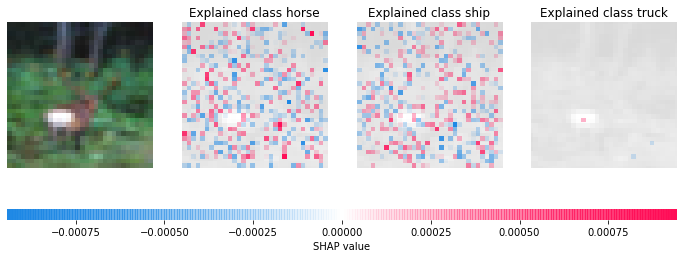

Explained Shapley values for sample 4


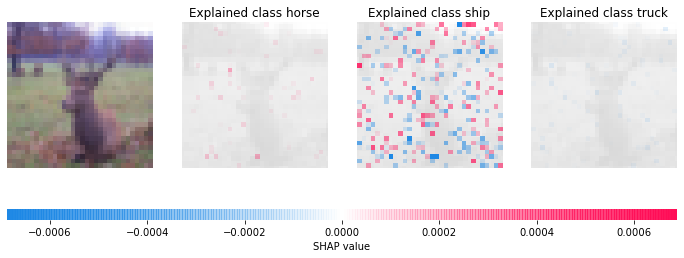

Explained Shapley values for sample 5


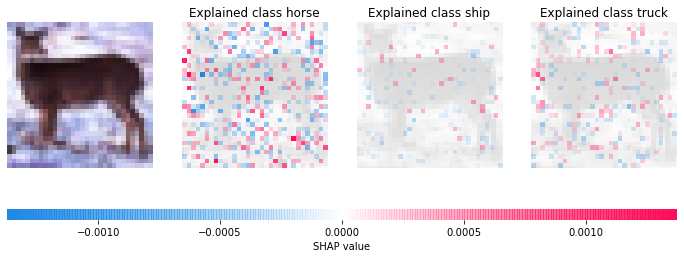

Explained Shapley values for sample 6


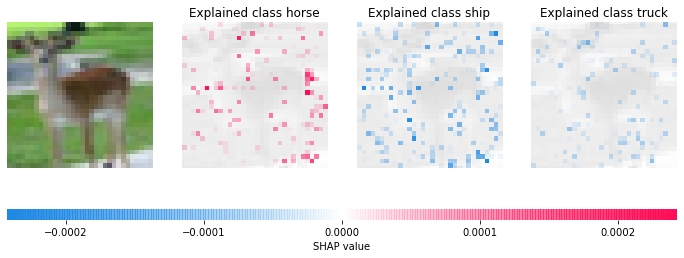

Explained Shapley values for sample 7


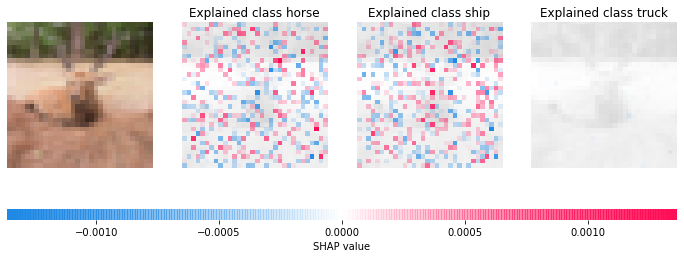

In [114]:
plot_shap_values(shap_values=list(shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)

Explained Shapley values for sample 0


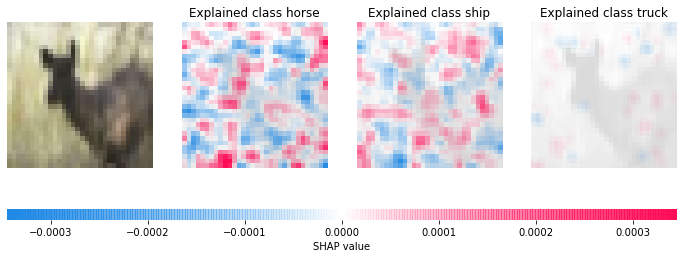

Explained Shapley values for sample 1


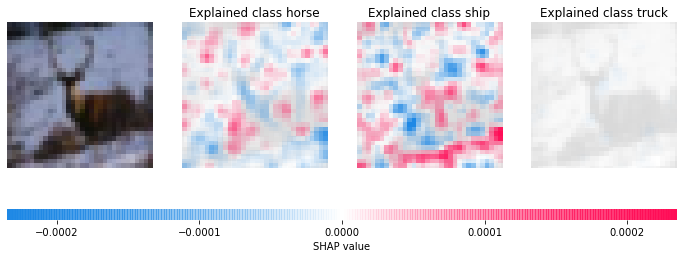

Explained Shapley values for sample 2


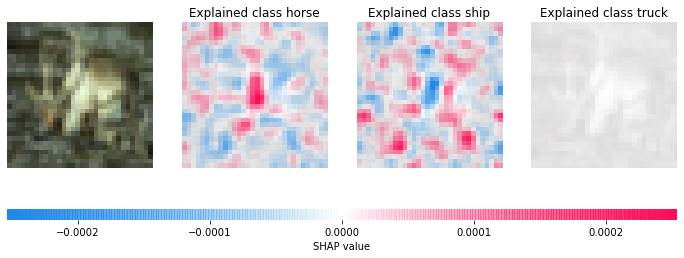

Explained Shapley values for sample 3


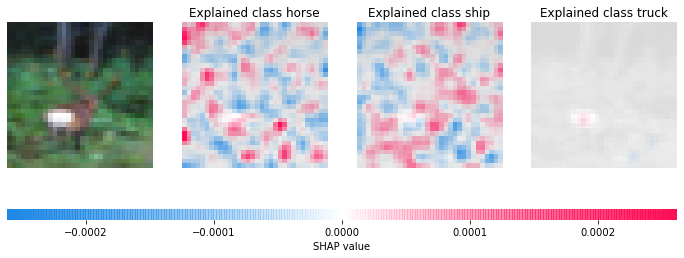

Explained Shapley values for sample 4


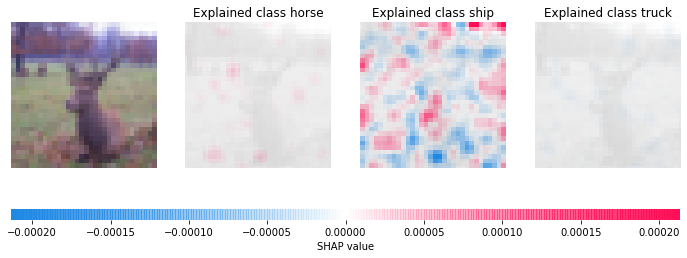

Explained Shapley values for sample 5


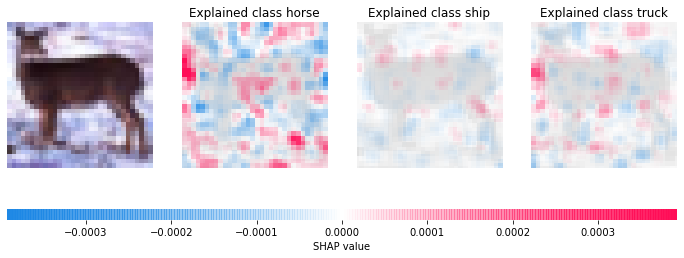

Explained Shapley values for sample 6


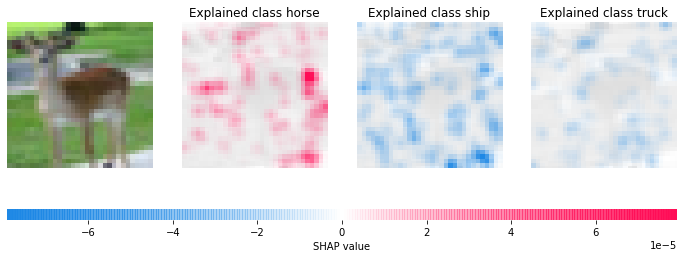

Explained Shapley values for sample 7


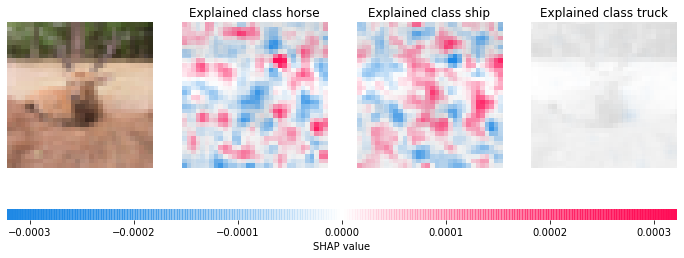

In [115]:
blurred_shhh = blur_shap_values(shhh, 1)
plot_shap_values(shap_values=list(blurred_shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)